# Dermatorlogist AI

We will design an algorithm that can visually diagnose **melanoma**, the deadliest from of skin cancer.

The algorithm will distinguish this malignant skin tummor from two types of benign lesions (**Nevus**, **Seborrheic keratosis**)

![skin tumor](images/skin_disease_classes.png)

### Import Libraries

In [1]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

In [2]:
# Data loaders for training, validation, and test sets
# Using meand and std dev from the ImageNet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define Batch size
BATCH_SIZE = 20

# Composition of the transforms
data_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# Load images
train_set = datasets.ImageFolder(root='data/test', transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=2)

In [3]:
# Loading classes
classes = train_set.classes
print('Classes: ', classes)
n_classes = len(train_set.classes)

Classes:  ['melanoma', 'nevus', 'seborrheic_keratosis']


### Visualize the data

In [4]:
data_iter = iter(train_loader)
images, classes_ = data_iter.next()

In [5]:
# Function to return an unnormalized image
def img_show(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None] # unnormalize
    np_img = img.numpy()
    return np.transpose(np_img, (1, 2, 0))

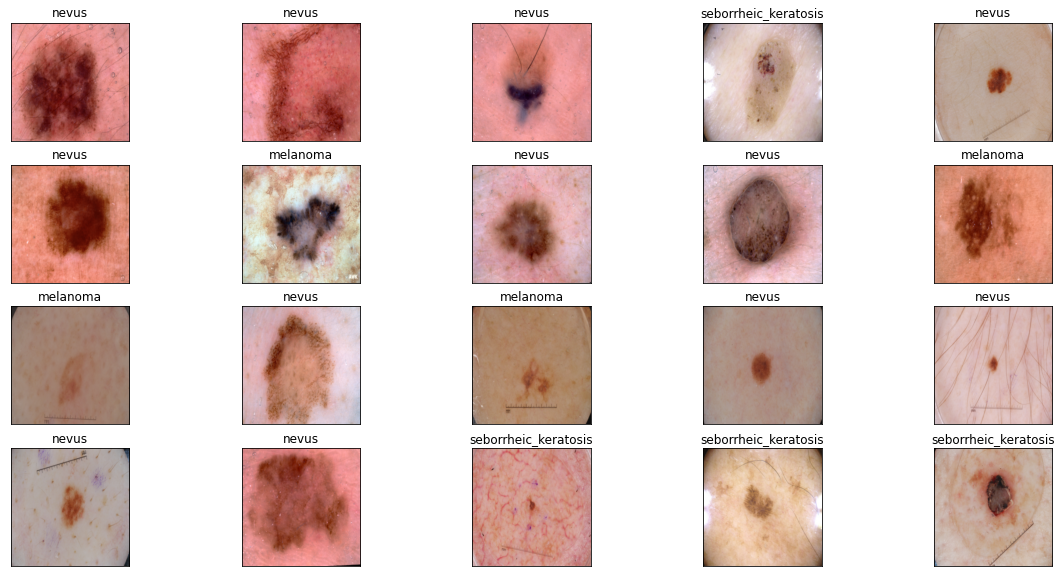

In [6]:
# Plot the images in the batch with their corresponding class names
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img_show(images[idx], torch.Tensor(mean), torch.Tensor(std)))
    ax.set_title(classes[classes_[idx]])
plt.show()

### Initialize CUDA variable

In [7]:
use_cuda = torch.cuda.is_available()
print('Use CUDA: ', use_cuda)

Use CUDA:  False


### Define a Convolutional Neural Network

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1),
        
        self.pool = nn.MaxPool2d(2, 2),
        
        self.fc1 = nn.Linear(32 * 16 * 16, 128),
        self.fc2 = nn.Linear(128, 64),
        self.fc3 = nn.Linear(64, n_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()
if use_cuda:
    model.cuda()

In [12]:
print(model)

Net(
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


### Define a Loss Function and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Train the network